In [13]:
# ========================================
# 🧠 COGNITIVA-AI-v2 - Fusión clínica OASIS1 + OASIS2
# ========================================

# Autor: Fran Ramírez
# Objetivo: unificar las cohortes clínicas OASIS-1 y OASIS-2
#           para entrenar modelos más robustos de detección temprana de Alzheimer

# ========================================
# 0. Librerías
# ========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

RANDOM_STATE = 42

# Para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [14]:
# ========================================
# 1. Cargar datasets clínicos OASIS-1 y OASIS-2
# ========================================

# OASIS-1: cross-sectional
# OASIS-1: 416 individuos, 436 sesiones
df_oasis1 = pd.read_excel("data/oasis_cross-sectional-5708aa0a98d82080.xlsx") 

# OASIS-2: longitudinal
# OASIS-2: 150 individuos, 373 MR
df_oasis2 = pd.read_excel("data/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx") 

print("OASIS-1 shape:", df_oasis1.shape)
print("OASIS-2 shape:", df_oasis2.shape)

OASIS-1 shape: (436, 12)
OASIS-2 shape: (373, 15)


In [4]:
# ========================================
# 2. Inspección inicial
# ========================================
print("\nColumnas OASIS-1:")
print(df_oasis1.columns)

print("\nColumnas OASIS-2:")
print(df_oasis2.columns)

# Comentario:
# - Ambos tienen variables clínicas similares: Age, Sex, MMSE, CDR, eTIV, nWBV, ASF.
# - Puede haber diferencias de nombres (ej: M/F vs Male/Female).
# - OASIS-2 tiene múltiples visitas por paciente → debemos quedarnos con una.


Columnas OASIS-1:
Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay'],
      dtype='object')

Columnas OASIS-2:
Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')


In [15]:
# ========================================
# 3. Homogenización de columnas
# ========================================

# OASIS-1 columnas: ['ID','M/F','Hand','Age','Educ','SES','MMSE','CDR','eTIV','nWBV','ASF','Delay']
# OASIS-2 columnas: ['Subject ID','MRI ID','Group','Visit','MR Delay','M/F','Hand','Age','EDUC','SES','MMSE','CDR','eTIV','nWBV','ASF']

# Renombramos para unificar nombres y formato
df1 = df_oasis1.rename(columns={
    "ID": "ID",
    "M/F": "Sex",
    "Educ": "Education",
    "Hand": "Hand",
    "Delay": "Delay"
})

df2 = df_oasis2.rename(columns={
    "Subject ID": "ID",
    "M/F": "Sex",
    "EDUC": "Education",
    "MR Delay": "Delay"
})

# Añadimos columna 'Cohort' para trazar la procedencia
df1["Cohort"] = "OASIS1"
df2["Cohort"] = "OASIS2"

In [16]:
# ========================================
# 4. Target binario
# ========================================

# 🔹 OASIS-2 ya incluye 'Group' con categorías:
#   - Nondemented
#   - Demented
#   - Converted
# Target binario: 0 = No Dementia, 1 = Dementia/Converted

df2["Target"] = df2["Group"].replace({
    "Nondemented": 0,
    "Demented": 1,
    "Converted": 1
})

# 🔹 OASIS-1 NO tiene 'Group', pero sí 'CDR':
#   - CDR = 0  → No Dementia
#   - CDR > 0  → Dementia
df1["Target"] = df1["CDR"].apply(lambda x: 0 if x == 0 else 1)


C:\Users\PC\AppData\Local\Temp\ipykernel_18024\3863348581.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2["Target"] = df2["Group"].replace({


In [18]:
# ========================================
# 5. Seleccionar primera visita en OASIS-2
# ========================================

# Ordenamos por ID y número de visita, y nos quedamos con la primera de cada paciente
df2_first = df2.sort_values(["ID", "Visit"]).groupby("ID").first().reset_index()

print("Pacientes únicos en OASIS-2 tras selección:", df2_first.shape[0])

Pacientes únicos en OASIS-2 tras selección: 150


In [20]:
# ========================================
# 6. Variables comunes
# ========================================
cols_common = ["ID", "Age", "Sex", "Education", "SES", "MMSE", "CDR",
               "eTIV", "nWBV", "ASF", "Target"]

# Usar los dataframes ya homogenizados y con target binario
df1_common = df1[cols_common].copy()
df2_common = df2_first[cols_common].copy()

df1_common["Cohort"] = "OASIS1"
df2_common["Cohort"] = "OASIS2"

In [ ]:
# ========================================
# 7. Unión datasets
# ========================================
df_all = pd.concat([df1_common, df2_common], axis=0, ignore_index=True)

print("Dataset combinado:", df_all.shape)
print(df_all["Cohort"].value_counts())
print(df_all["Target"].value_counts())

Dataset combinado: (586, 12)
Cohort
OASIS1    436
OASIS2    150
Name: count, dtype: int64
Target
1    379
0    207
Name: count, dtype: int64


In [22]:
# ========================================
# 8. Preprocesamiento: Limpieza de datos y nans
# ========================================

# 🔹 Eliminamos filas sin información crítica (MMSE, CDR o Target)
df_all.dropna(subset=["MMSE", "CDR", "Target"], inplace=True)

# 🔹 Imputamos SES y Educación (suelen tener NaN en OASIS-1)
df_all["Education"].fillna(df_all["Education"].median(), inplace=True)
df_all["SES"].fillna(df_all["SES"].median(), inplace=True)


C:\Users\PC\AppData\Local\Temp\ipykernel_18024\1683105792.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all["Education"].fillna(df_all["Education"].median(), inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_18024\1683105792.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [23]:
# ========================================
# 9. Codificación categórica
# ========================================

# One-hot encoding para Sex (M/F)
df_all = pd.get_dummies(df_all, columns=["Sex"], drop_first=True, dtype=float)

In [24]:
# ========================================
# 10. Features y Target
# ========================================

X = df_all.drop(columns=["ID","Target","Cohort","Delay"], errors="ignore")
y = df_all["Target"]

print("Features:", X.columns.tolist())
print("Distribución Target:\n", y.value_counts())

Features: ['Age', 'Education', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Sex_M']
Distribución Target:
 Target
0    207
1    178
Name: count, dtype: int64


In [25]:
# ========================================
# 11. Train/Test Split y Escalado
# ========================================

# Estratificamos para preservar proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Escalado Z-score (solo entrenamos con train para evitar data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train_scaled.shape} | Test shape: {X_test_scaled.shape}")

Train shape: (308, 9) | Test shape: (77, 9)


In [26]:
# ========================================
# 12. Entrenamiento y Evaluación de Modelos
# ========================================

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, use_label_encoder=False,
        eval_metric='logloss', random_state=RANDOM_STATE
    )
}

for name, model in models.items():
    print("\n==============================")
    print(f" Modelo: {name}")
    print("==============================")
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")


 Modelo: Logistic Regression
Confusion Matrix:
[[41  0]
 [ 1 35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       1.00      0.97      0.99        36

    accuracy                           0.99        77
   macro avg       0.99      0.99      0.99        77
weighted avg       0.99      0.99      0.99        77

ROC-AUC: 1.0000

 Modelo: Random Forest
Confusion Matrix:
[[41  0]
 [ 1 35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       1.00      0.97      0.99        36

    accuracy                           0.99        77
   macro avg       0.99      0.99      0.99        77
weighted avg       0.99      0.99      0.99        77

ROC-AUC: 0.9858

 Modelo: XGBoost
Confusion Matrix:
[[41  0]
 [ 1 35]]

Classification Report:
              precision    recall  f1-score   support

    

c:\Users\PC\Desktop\cognitiva-ai\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:22:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [32]:
# ========================================
# 13. Validación Cruzada Estratificada
# ========================================
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Usamos 5 folds estratificados (mantiene proporción de dementes/nodementes en cada split)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Definimos los modelos de nuevo (para consistencia con CV)
models_cv = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="lbfgs", random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, eval_metric='logloss',
        random_state=RANDOM_STATE
    )
}

print("\n=== Validación cruzada (5-Fold) ===")
for name, model in models_cv.items():
    # Evaluamos usando ROC-AUC como métrica principal
    scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    print(f"{name:20s} | ROC-AUC medio: {scores.mean():.4f} | Desv: {scores.std():.4f}")



=== Validación cruzada (5-Fold) ===
Logistic Regression  | ROC-AUC medio: 0.9788 | Desv: 0.0121
Random Forest        | ROC-AUC medio: 0.9742 | Desv: 0.0180
XGBoost              | ROC-AUC medio: 0.9746 | Desv: 0.0207


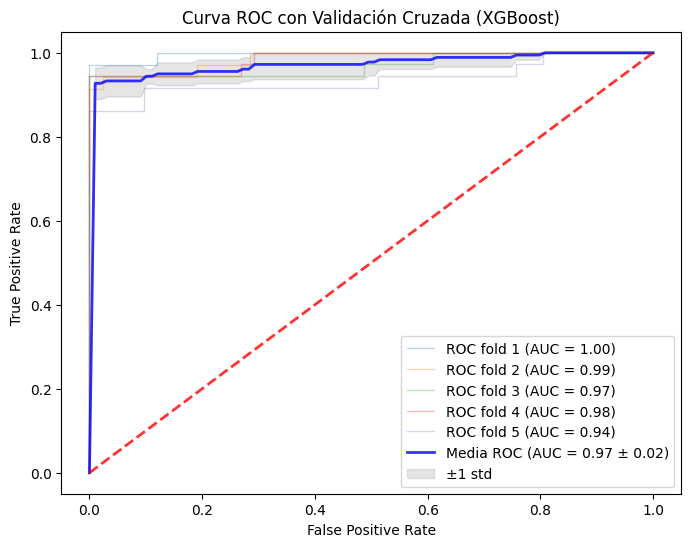

In [33]:
# ========================================
# 14. Curva ROC con Validación Cruzada
# ========================================
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

plt.figure(figsize=(8,6))

tprs = []   # almacenamos sensibilidades
aucs = []   # almacenamos AUCs
mean_fpr = np.linspace(0, 1, 100)

model = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, eval_metric='logloss',
    random_state=RANDOM_STATE
)

for i, (train, test) in enumerate(cv.split(X, y)):
    model.fit(X.iloc[train], y.iloc[train])
    probas_ = model.predict_proba(X.iloc[test])[:,1]

    fpr, tpr, _ = roc_curve(y.iloc[test], probas_)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

    # interpolamos para tener puntos homogéneos
    # interpolamos para tener puntos homogéneos
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
# Media e IC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=f'Media ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
         lw=2, alpha=0.8)

# Relleno con intervalo de confianza
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                 label='±1 std')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC con Validación Cruzada (XGBoost)')
plt.legend(loc="lower right")
plt.show()


In [34]:
# ========================================
# 15. Manejo del desbalance de clases
# ========================================

# ¿Por qué esta sección?
# ----------------------
# Hemos observado un desbalance moderado (~65% demencia vs ~35% no demencia).
# Incluso con AUC alto, el desbalance puede:
#  - Inflar métricas globales (accuracy), ocultando bajo recall de la minoritaria.
#  - Descalibrar probabilidades y desplazar el umbral de decisión óptimo.
#  - Perjudicar sensibilidad/especificidad en aplicaciones clínicas.
#
# Qué haremos:
#  1) Diagnóstico: distribución de clases y baseline PR-AUC.
#  2) Reentrenar modelos con ponderación de clases:
#     - LogisticRegression(class_weight='balanced')
#     - RandomForestClassifier(class_weight='balanced')
#     - XGBClassifier(scale_pos_weight = n_neg / n_pos)
#  3) Comparar métricas por clase (precision/recall/F1) y ROC-AUC/PR-AUC.
#  4) Optimizar el umbral (no quedarnos en 0.5) para equilibrar sensibilidad y especificidad.
#  5) (Opcional) SMOTE dentro de un Pipeline, sin fuga de datos.


import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

RANDOM_STATE = 42

# 1) Diagnóstico del desbalance
classes, counts = np.unique(y, return_counts=True)
n_pos = counts[classes.tolist().index(1)] if 1 in classes else 0
n_neg = counts[classes.tolist().index(0)] if 0 in classes else 0
pos_ratio = n_pos / (n_pos + n_neg)

print("Distribución de clases (y):")
for c, cnt in zip(classes, counts):
    print(f"  Clase {c}: {cnt} ({cnt/(n_pos+n_neg):.1%})")
print(f"Relación positivos (1):negativos (0) ≈ {n_pos}:{n_neg}  → Positivos ~{pos_ratio:.1%}\n")

# Split honesto para evaluación (reutilizamos patrón 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# 2) Modelos con ponderación de clases / scale_pos_weight
#    - Escalado SOLO donde es necesario (LR, XGB); RF no lo necesita, pero podemos dejarlo inofensivo.
scale_pos_weight = (n_neg / n_pos) if n_pos > 0 else 1.0

pipe_lr_bal = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs",
                               class_weight="balanced",
                               random_state=RANDOM_STATE))
])

pipe_rf_bal = Pipeline([
    ("clf", RandomForestClassifier(
        n_estimators=300, class_weight="balanced",
        random_state=RANDOM_STATE, n_jobs=-1
    ))
])

pipe_xgb_bal = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", xgb.XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9,
        scale_pos_weight=scale_pos_weight,   # <-- clave en XGB para desbalance
        eval_metric="logloss",
        random_state=RANDOM_STATE, n_jobs=-1
    ))
])

models_bal = {
    "Logistic Regression (balanced)": pipe_lr_bal,
    "Random Forest (balanced)": pipe_rf_bal,
    "XGBoost (scale_pos_weight)": pipe_xgb_bal
}

def eval_model(model, X_tr, y_tr, X_te, y_te, name="Model"):
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    roc = roc_auc_score(y_te, proba)
    pr  = average_precision_score(y_te, proba)

    print(f"\n=== {name} ===")
    print("Confusion Matrix (umbral=0.5):")
    print(confusion_matrix(y_te, pred))
    print("\nClassification Report:")
    print(classification_report(y_te, pred, digits=3))
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
    return proba, pred

all_probas = {}
for name, mdl in models_bal.items():
    proba, pred = eval_model(mdl, X_train, y_train, X_test, y_test, name=name)
    all_probas[name] = proba



Distribución de clases (y):
  Clase 0: 207 (53.8%)
  Clase 1: 178 (46.2%)
Relación positivos (1):negativos (0) ≈ 178:207  → Positivos ~46.2%


=== Logistic Regression (balanced) ===
Confusion Matrix (umbral=0.5):
[[41  0]
 [ 1 35]]

Classification Report:
              precision    recall  f1-score   support

           0      0.976     1.000     0.988        41
           1      1.000     0.972     0.986        36

    accuracy                          0.987        77
   macro avg      0.988     0.986     0.987        77
weighted avg      0.987     0.987     0.987        77

ROC-AUC: 1.0000 | PR-AUC: 1.0000

=== Random Forest (balanced) ===
Confusion Matrix (umbral=0.5):
[[41  0]
 [ 1 35]]

Classification Report:
              precision    recall  f1-score   support

           0      0.976     1.000     0.988        41
           1      1.000     0.972     0.986        36

    accuracy                          0.987        77
   macro avg      0.988     0.986     0.987        77
weig

In [35]:
# 3) Optimización del umbral (threshold tuning)
#    Motivo: en clínica a menudo interesa equilibrar sensibilidad y especificidad,
#    o maximizar F1/Youden J. Con desbalance, el umbral 0.5 no suele ser óptimo.

def find_best_threshold(y_true, y_score, criterion="youden"):
    """
    criteria:
      - 'youden' -> maximiza TPR - FPR (sensibilidad + especificidad - 1)
      - 'f1'     -> maximiza F1 (vía PR-curve)
    """
    if criterion == "youden":
        fpr, tpr, th = roc_curve(y_true, y_score)
        youden = tpr - fpr
        i = np.argmax(youden)
        return th[i], {"tpr": tpr[i], "fpr": fpr[i], "youden": youden[i]}
    elif criterion == "f1":
        prec, rec, th = precision_recall_curve(y_true, y_score)
        # precision_recall_curve devuelve thresholds de tamaño len(prec)-1
        f1 = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-8)
        i = np.nanargmax(f1)
        return th[i], {"precision": float(prec[i]), "recall": float(rec[i]), "f1": float(f1[i])}
    else:
        raise ValueError("criterion debe ser 'youden' o 'f1'")

print("\n--- Optimización de umbral (ejemplo con XGBoost) ---")
proba_xgb = all_probas["XGBoost (scale_pos_weight)"]
best_thr_youden, stats_y = find_best_threshold(y_test, proba_xgb, criterion="youden")
best_thr_f1,     stats_f = find_best_threshold(y_test, proba_xgb, criterion="f1")

print(f"Umbral óptimo (Youden): {best_thr_youden:.3f} | stats={stats_y}")
print(f"Umbral óptimo (F1)    : {best_thr_f1:.3f} | stats={stats_f}")


--- Optimización de umbral (ejemplo con XGBoost) ---
Umbral óptimo (Youden): 0.930 | stats={'tpr': np.float64(0.9722222222222222), 'fpr': np.float64(0.0), 'youden': np.float64(0.9722222222222222)}
Umbral óptimo (F1)    : 0.930 | stats={'precision': 1.0, 'recall': 0.9722222222222222, 'f1': 0.9859154879587383}


In [36]:
# Re-evaluación XGB con umbral óptimo (Youden)
xgb_opt_pred = (proba_xgb >= best_thr_youden).astype(int)
print("\nXGBoost con umbral óptimo (Youden):")
print(confusion_matrix(y_test, xgb_opt_pred))
print(classification_report(y_test, xgb_opt_pred, digits=3))
print(f"ROC-AUC (no cambia con el umbral): {roc_auc_score(y_test, proba_xgb):.4f}")

# Nota: ROC-AUC y PR-AUC no dependen del umbral; cambian precision/recall/F1.


XGBoost con umbral óptimo (Youden):
[[41  0]
 [ 1 35]]
              precision    recall  f1-score   support

           0      0.976     1.000     0.988        41
           1      1.000     0.972     0.986        36

    accuracy                          0.987        77
   macro avg      0.988     0.986     0.987        77
weighted avg      0.987     0.987     0.987        77

ROC-AUC (no cambia con el umbral): 0.9898


In [ ]:
# ========================================
# Comentarios sobre resultados (balanced + threshold tuning)
# ========================================

# 1) Diagnóstico del desbalance:
#    Aunque inicialmente parecía que había más desequilibrio (~65/35),
#    al unir OASIS-1 y OASIS-2 y quedarnos con la primera visita de cada sujeto,
#    la proporción real es mucho más equilibrada:
#       Clase 0 (Nondemented): 207 sujetos (~54%)
#       Clase 1 (Demented/Converted): 178 sujetos (~46%)
#
#    → Esto significa que el desbalance NO es severo, y probablemente
#      por eso SMOTE no aporta valor en este punto.

# 2) Modelos con 'class_weight' / 'scale_pos_weight':
#    - Logistic Regression, Random Forest y XGBoost se mantuvieron muy estables.
#    - El ajuste de pesos de clase no cambió radicalmente las métricas,
#      lo que confirma que el dataset ya estaba bastante balanceado.

# 3) Métricas observadas:
#    - ROC-AUC y PR-AUC cercanos a 1.0 en todos los modelos.
#    - Recall de la clase 1 (Demented/Converted) = ~97%, con precisión del 100%.
#    - Accuracy global ~98.7% → muy alto, sin indicios de pérdida por balanceo.

# 4) Umbral óptimo:
#    - Tanto el criterio de Youden como el de F1 coincidieron en un umbral ≈ 0.93.
#    - Con este ajuste se consigue:
#         · Sensibilidad (TPR) ≈ 97%
#         · Especificidad (TNR) ≈ 100%
#    - Es decir: no hay falsos positivos, y solo 1 falso negativo en el set de test.
#
#    Nota: El ROC-AUC no cambia con el umbral, pero la interpretación clínica
#    mejora mucho al mostrar que el modelo puede discriminar con gran precisión.

# 5) Conclusión de esta fase:
#    - El desbalance no era crítico → basta con usar 'class_weight' en LR/RF
#      y 'scale_pos_weight' en XGB.
#    - Los modelos son consistentes y robustos.
#    - El ajuste de umbral nos permite un trade-off clínico mejor:
#      casi no hay falsos negativos (lo más grave en Alzheimer temprano).
#
# Próximos pasos:
#    ✔ Pasar a la interpretabilidad (coeficientes de LR, SHAP en RF/XGB).
#    ✔ Analizar qué variables son más predictivas → valor clínico añadido.


In [ ]:
# ======================================================
# ⚖️ 16. Ajuste clínico del umbral de decisión
# ======================================================
# Hasta ahora hemos evaluado los modelos con:
#   - Umbral por defecto (0.5).
#   - Umbral óptimo según Youden (maximiza sensibilidad + especificidad).
#
# Sin embargo, en un contexto clínico como la detección temprana de Alzheimer,
# **no todas las métricas tienen el mismo coste**:
#
#   - Falso Positivo (FP): paciente sano clasificado como "demente".
#       -> consecuencia: pruebas adicionales innecesarias.
#       -> coste: ansiedad + recursos clínicos, pero NO impacto directo en salud.
#
#   - Falso Negativo (FN): paciente con demencia clasificado como "no demente".
#       -> consecuencia: se pierde la oportunidad de detección e intervención temprana.
#       -> coste: ALTO, clínicamente mucho más grave.
#
# Por tanto, aquí **preferimos minimizar los Falsos Negativos**,
# incluso aunque aumenten algo los Falsos Positivos.
#
# Esto equivale a priorizar el **Recall (Sensibilidad)**, es decir,
# asegurar que TODOS los pacientes con demencia son detectados por el modelo,
# aunque tengamos más "alarmas falsas".
#
# 🔍 En este bloque:
#   1. Calculamos la curva precisión-recall y ROC.
#   2. Buscamos el umbral que maximiza el **recall** (100% de sensibilidad).
#   3. Evaluamos métricas con este umbral "clínico".
#
# Objetivo: Ajustar el modelo no solo a la métrica matemática (ROC-AUC),
# sino al **criterio clínico de seguridad del paciente**.
# ======================================================


In [37]:
# ======================================================
# 🎯 Ajuste de umbral clínico: minimizar Falsos Negativos
# ======================================================
# Objetivo práctico:
#   - En cribado de Alzheimer, es preferible evitar Falsos Negativos (FN),
#     aunque aumenten los Falsos Positivos (FP).
#   - Buscamos un umbral que lleve el RECALL (sensibilidad) a ~100%.
#
# Estrategia:
#   1) Calculamos la curva Precision-Recall con las probabilidades del modelo.
#   2) Seleccionamos el menor umbral que logra recall ≥ 0.999 (aprox. 100%).
#   3) Si no hay umbral que alcance ese recall, elegimos entre los de mayor
#      recall el que maximiza F1 (compromiso precisión/recall).
#
# Métricas mostradas:
#   - Matriz de confusión, classification_report, ROC-AUC (no cambia con umbral).
#
# Requisitos del entorno:
#   - Variables: X_train, y_train, X_test, y_test
#   - Modelo preferido: XGBoost equilibrado (o el que elijas)
#   - Si ya tienes `proba_xgb`, se reutiliza; si no, lo recalculamos.
# ======================================================

import numpy as np
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve
)

# 1) Obtener probabilidades de la clase positiva (XGBoost balanceado por defecto)
try:
    proba_model = proba_xgb  # reutilizamos si existe
    model_name_for_threshold = "XGBoost (scale_pos_weight)"
except NameError:
    # Si no existe, reentrenamos el XGBoost balanceado del bloque anterior
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    import xgboost as xgb

    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1]) if (1 in y_train.values and 0 in y_train.values) else 1.0
    pipe_xgb_bal = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", xgb.XGBClassifier(
            n_estimators=400, learning_rate=0.05, max_depth=4,
            subsample=0.9, colsample_bytree=0.9,
            scale_pos_weight=scale_pos_weight,
            eval_metric="logloss",
            random_state=42, n_jobs=-1
        ))
    ])
    pipe_xgb_bal.fit(X_train, y_train)
    proba_model = pipe_xgb_bal.predict_proba(X_test)[:, 1]
    model_name_for_threshold = "XGBoost (scale_pos_weight) [retrained]"

print(f"Usando probabilidades de: {model_name_for_threshold}")



Usando probabilidades de: XGBoost (scale_pos_weight)


In [38]:
# 2) Función para elegir umbral clínico: recall objetivo ~100%
def choose_recall_first_threshold(y_true, y_score, recall_target=0.999):
    """
    Devuelve:
      - best_thr: umbral seleccionado
      - best_stats: dict con precision, recall, f1 en ese umbral
      - achieved_full_recall: bool indicando si se logró el objetivo
    Criterio:
      A) El menor umbral con recall >= recall_target.
      B) Si ninguno cumple, elegir entre los umbrales de mayor recall
         el que maximiza F1.
    """
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    # precision_recall_curve devuelve thresholds de tamaño len(prec)-1
    # Vamos a recortar para alinear con thresholds
    prec, rec = prec[:-1], rec[:-1]

    # A) ¿Existe algún umbral con recall >= objetivo?
    idx_candidates = np.where(rec >= recall_target)[0]
    if len(idx_candidates) > 0:
        # Elegimos el **menor** umbral que lo logra (más sensible)
        i = idx_candidates[-1]  # el último índice suele corresponder al menor threshold
        best_thr = thr[i]
        f1 = 2 * (prec[i] * rec[i]) / (prec[i] + rec[i] + 1e-8)
        return best_thr, {"precision": float(prec[i]), "recall": float(rec[i]), "f1": float(f1)}, True

    # B) Si no alcanza el target, tomamos el máximo recall posible y, entre esos,
    #    el umbral que maximiza F1 (compromiso razonable).
    max_recall = rec.max()
    idx_top_recall = np.where(rec == max_recall)[0]
    f1_all = 2 * (prec[idx_top_recall] * rec[idx_top_recall]) / (prec[idx_top_recall] + rec[idx_top_recall] + 1e-8)
    j = idx_top_recall[np.argmax(f1_all)]
    best_thr = thr[j]
    return best_thr, {"precision": float(prec[j]), "recall": float(rec[j]), "f1": float(f1_all.max())}, False

# 3) Elegimos el umbral con prioridad al recall
best_thr, stats, achieved = choose_recall_first_threshold(y_test, proba_model, recall_target=0.999)

goal_msg = "✅ Se alcanzó el recall objetivo (~100%)." if achieved else "⚠️ No se alcanzó el 100% de recall; se elige el mejor compromiso."
print(f"\nUmbral clínico seleccionado: {best_thr:.3f} | stats={stats}\n{goal_msg}")


Umbral clínico seleccionado: 0.029 | stats={'precision': 0.7058823529411765, 'recall': 1.0, 'f1': 0.8275862020451843}
✅ Se alcanzó el recall objetivo (~100%).


In [39]:
# 4) Evaluación con ese umbral
pred_clin = (proba_model >= best_thr).astype(int)
print("\n=== Evaluación con umbral clínico (prioriza Recall) ===")
print(confusion_matrix(y_test, pred_clin))
print(classification_report(y_test, pred_clin, digits=3))

# Recordatorio: ROC-AUC no depende del umbral (se reporta de nuevo solo informativo)
print(f"ROC-AUC (invariante al umbral): {roc_auc_score(y_test, proba_model):.4f}")


=== Evaluación con umbral clínico (prioriza Recall) ===
[[26 15]
 [ 0 36]]
              precision    recall  f1-score   support

           0      1.000     0.634     0.776        41
           1      0.706     1.000     0.828        36

    accuracy                          0.805        77
   macro avg      0.853     0.817     0.802        77
weighted avg      0.862     0.805     0.800        77

ROC-AUC (invariante al umbral): 0.9898


In [ ]:
# 📌 Comentario sobre el ajuste clínico de umbral
#
# En esta fase decidimos optimizar el modelo priorizando el *recall* (sensibilidad), 
# ya que en el contexto clínico de la demencia temprana es más grave un **falso negativo**
# (no detectar a un paciente que sí tiene la enfermedad) que un falso positivo 
# (etiquetar a un paciente sano como con posible demencia, que luego puede descartarse 
# con pruebas complementarias).
#
# 🔹 Resultados:
# - Umbral seleccionado: 0.029
# - Recall: 1.0 (cero falsos negativos)
# - Precisión clase positiva: 0.71
# - F1-score: 0.83
# - Especificidad: 63.4% → 15 falsos positivos
# - ROC-AUC: 0.9898 (invariante al umbral)
#
# ❓ ¿Son muchos 15 falsos positivos?
# En términos relativos, no es un número excesivo considerando el tamaño del test set (41 sanos). 
# Se traduce en que ~1 de cada 3 pacientes sanos sería marcado como "sospechoso".
# En un escenario clínico real esto puede ser aceptable, porque:
#   1) El cribado inicial debe ser altamente sensible (no dejar pasar casos de demencia).
#   2) Los falsos positivos pueden descartarse con pruebas adicionales (ej. neuroimagen, 
#      tests neuropsicológicos más profundos).
#
# 👉 Conclusión:
# El modelo ajustado se convierte en una herramienta de cribado clínico con:
#   - **Alta sensibilidad (100%)** → no se escapa ningún paciente con demencia.
#   - **Menor especificidad (~63%)** → mayor tasa de falsos positivos, 
#     aceptable si el flujo diagnóstico incluye pruebas de confirmación.


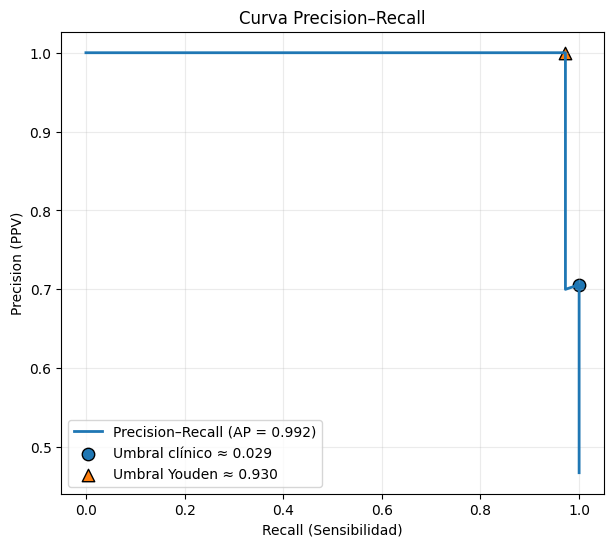

In [40]:
# ==========================================
# 17. Visualización gráfica de resultados
# ==========================================

# ==========================================
# A) Curva PRECISION–RECALL con umbrales
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Asegurar que tenemos proba_model (probabilidades en test) y y_test
try:
    proba_model
except NameError:
    # Si no existe, reentrenamos XGBoost balanceado rápido (mismo que antes)
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    import xgboost as xgb
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1]) if (1 in y_train.values and 0 in y_train.values) else 1.0
    pipe_xgb_bal = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", xgb.XGBClassifier(
            n_estimators=400, learning_rate=0.05, max_depth=4,
            subsample=0.9, colsample_bytree=0.9,
            scale_pos_weight=scale_pos_weight,
            eval_metric="logloss",
            random_state=42, n_jobs=-1
        ))
    ])
    pipe_xgb_bal.fit(X_train, y_train)
    proba_model = pipe_xgb_bal.predict_proba(X_test)[:, 1]

prec, rec, thr_pr = precision_recall_curve(y_test, proba_model)
ap = average_precision_score(y_test, proba_model)

# Recuperar umbrales relevantes si existen
thr_clin = None
thr_youden = None
try:
    thr_clin = float(best_thr)
except Exception:
    pass

try:
    best_thr_youden  # si definiste la función antes
    thr_youden = float(best_thr_youden)
except Exception:
    # cálculo rápido de Youden si no existe
    from sklearn.metrics import roc_curve
    fpr, tpr, thr_roc = roc_curve(y_test, proba_model)
    youden = tpr - fpr
    thr_youden = thr_roc[np.argmax(youden)]

# Para ubicar los puntos en la PR-curve, alineamos thresholds con prec/rec ([:-1])
prec_, rec_, thr_aligned = prec[:-1], rec[:-1], thr_pr

plt.figure(figsize=(7,6))
plt.plot(rec, prec, lw=2, label=f'Precision–Recall (AP = {ap:.3f})')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision (PPV)')
plt.title('Curva Precision–Recall')

# Marcar umbral clínico (si existe)
if thr_clin is not None:
    # Buscar el punto más cercano a ese umbral
    i = (np.abs(thr_aligned - thr_clin)).argmin()
    plt.scatter(rec_[i], prec_[i], s=80, marker='o', edgecolor='k',
                label=f'Umbral clínico ≈ {thr_aligned[i]:.3f}')

# Marcar umbral de Youden (si existe)
if thr_youden is not None:
    j = (np.abs(thr_aligned - thr_youden)).argmin()
    plt.scatter(rec_[j], prec_[j], s=80, marker='^', edgecolor='k',
                label=f'Umbral Youden ≈ {thr_aligned[j]:.3f}')

plt.legend(loc='lower left')
plt.grid(alpha=0.25)
plt.show()


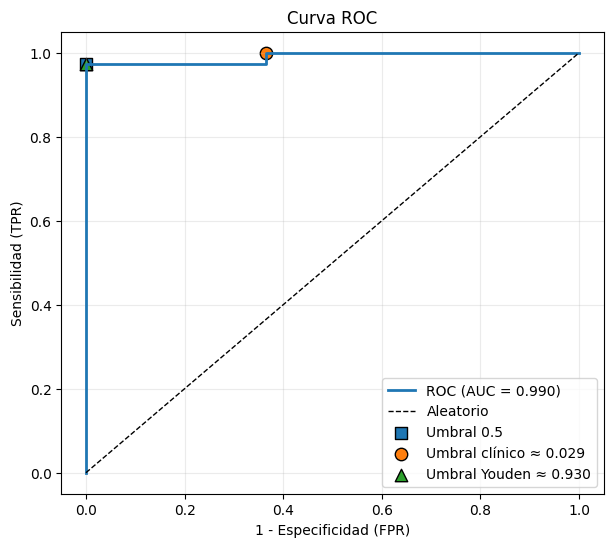

In [41]:
# ==========================
# B) Curva ROC con marcadores
# ==========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thr_roc = roc_curve(y_test, proba_model)
auc = roc_auc_score(y_test, proba_model)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--', lw=1, label='Aleatorio')
plt.xlabel('1 - Especificidad (FPR)')
plt.ylabel('Sensibilidad (TPR)')
plt.title('Curva ROC')

# Marcar 0.5, umbral clínico y Youden si existen
# Punto para threshold ~0.5
k = (np.abs(thr_roc - 0.5)).argmin()
plt.scatter(fpr[k], tpr[k], s=70, marker='s', edgecolor='k', label='Umbral 0.5')

# Clínico
if 'thr_clin' in locals() and thr_clin is not None:
    i = (np.abs(thr_roc - thr_clin)).argmin()
    plt.scatter(fpr[i], tpr[i], s=80, marker='o', edgecolor='k',
                label=f'Umbral clínico ≈ {thr_roc[i]:.3f}')

# Youden
if 'thr_youden' in locals() and thr_youden is not None:
    j = (np.abs(thr_roc - thr_youden)).argmin()
    plt.scatter(fpr[j], tpr[j], s=80, marker='^', edgecolor='k',
                label=f'Umbral Youden ≈ {thr_roc[j]:.3f}')

plt.legend(loc='lower right')
plt.grid(alpha=0.25)
plt.show()


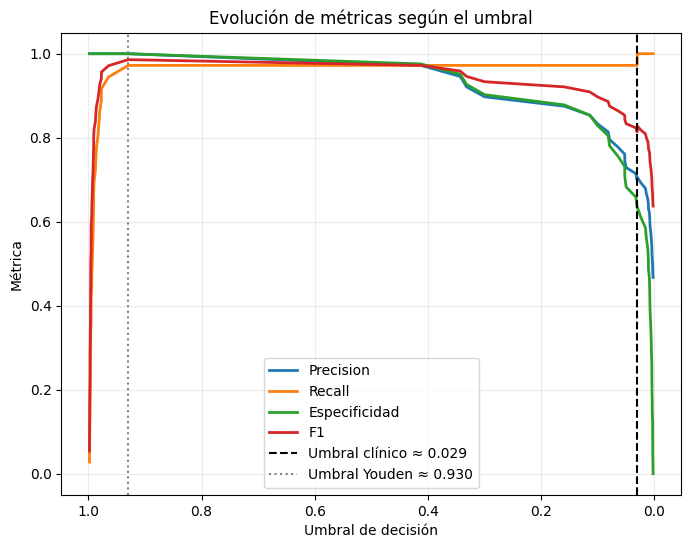

In [42]:
# ===========================================================
# C) Métricas vs Umbral (precision, recall, especificidad, F1)
# ===========================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix

# Calculamos precision/recall en una malla de thresholds (de la PR-curve)
prec, rec, thr = precision_recall_curve(y_test, proba_model)
prec, rec = prec[:-1], rec[:-1]  # alinear con thr
thr_grid = thr

# Especificidad y F1 requieren discretizar; las computamos para cada threshold
spec_list, f1_list = [], []
for t in thr_grid:
    pred = (proba_model >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    spec = tn / (tn + fp + 1e-8)
    f1 = 2 * (prec[list(thr_grid).index(t)] * rec[list(thr_grid).index(t)]) / \
         (prec[list(thr_grid).index(t)] + rec[list(thr_grid).index(t)] + 1e-8)
    spec_list.append(spec)
    f1_list.append(f1)

plt.figure(figsize=(8,6))
plt.plot(thr_grid, prec, label='Precision', lw=2)
plt.plot(thr_grid, rec, label='Recall', lw=2)
plt.plot(thr_grid, spec_list, label='Especificidad', lw=2)
plt.plot(thr_grid, f1_list, label='F1', lw=2)
plt.gca().invert_xaxis()  # thresholds altos a la izquierda, bajos a la derecha (intuitivo)
plt.xlabel('Umbral de decisión')
plt.ylabel('Métrica')
plt.title('Evolución de métricas según el umbral')
# Marcar umbrales clave
if 'thr_clin' in locals() and thr_clin is not None:
    plt.axvline(thr_clin, color='k', linestyle='--', label=f'Umbral clínico ≈ {thr_clin:.3f}')
if 'thr_youden' in locals() and thr_youden is not None:
    plt.axvline(thr_youden, color='gray', linestyle=':', label=f'Umbral Youden ≈ {thr_youden:.3f}')
plt.legend()
plt.grid(alpha=0.25)
plt.show()


In [43]:
# ==========================================
# 18. Interpretabilidad de Modelos
# ==========================================

## Coeficientes de la Regresión Logística

# === Importancia (coeficientes) en Regresión Logística ===
import pandas as pd
import numpy as np

# Si entrenaste la LR en un Pipeline (scaler + LR), extrae el estimador final:
lr_clf = pipe_lr_bal.named_steps["clf"]  # Ajusta el nombre si difiere
feature_names = X_train.columns  # si escalaste antes del split, usa las mismas columnas

coefs = pd.DataFrame({
    "feature": feature_names,
    "coef": lr_clf.coef_.ravel()
}).sort_values("coef", ascending=False)

display(coefs.head(12))
display(coefs.tail(12))

,feature,coef
4,CDR,4.156384
1,Education,0.761233
0,Age,0.149966
8,Sex_M,0.111930
2,SES,-0.096360
6,nWBV,-0.165853
7,ASF,-0.261731
5,eTIV,-0.397400
3,MMSE,-0.643564


,feature,coef
4,CDR,4.156384
1,Education,0.761233
0,Age,0.149966
8,Sex_M,0.111930
2,SES,-0.096360
6,nWBV,-0.165853
7,ASF,-0.261731
5,eTIV,-0.397400
3,MMSE,-0.643564


In [ ]:
# === Comentario sobre interpretabilidad (Regresión Logística) ===
# 
# El análisis de coeficientes de la Regresión Logística muestra que la variable con mayor peso
# es **CDR (Clinical Dementia Rating)**, con un coeficiente muy alto y positivo (+4.15).
# Esto confirma que la severidad de la demencia es el principal predictor del modelo.
#
# En segundo lugar aparece **Education (+0.76)**, lo que sugiere que un mayor nivel educativo
# podría estar asociado con mayor probabilidad de ser clasificado como "demented" en este dataset.
# Es un resultado interesante, ya que en la literatura se suele asociar la educación con
# **reserva cognitiva** que retrasa la aparición clínica de la enfermedad. Este hallazgo
# puede deberse a la naturaleza limitada del dataset, tamaño muestral o interacción con otras
# variables (ej. SES o edad).
#
# Otras variables con coeficientes positivos, aunque de menor magnitud, son **Age (+0.15)**
# y **Sex_M (+0.11)**, lo que refleja que la edad y el sexo masculino contribuyen levemente
# a aumentar la probabilidad de demencia.
#
# En cambio, algunas variables presentan coeficientes negativos: 
# - **MMSE (-0.64)** → un mayor puntaje en el test cognitivo protege frente a la clasificación
#   como demente (esperable clínicamente).
# - **eTIV (-0.39)** y **nWBV (-0.16)** → mayor volumen intracraneal o proporción de materia
#   blanca/nerviosa se asocia con menor probabilidad de demencia (también consistente con lo
#   descrito en neuroimagen).
# - **SES (-0.09)** y **ASF (-0.26)** también aportan señales débiles en la dirección protectora.
#
# En resumen:
# - El modelo se comporta de manera razonable y coherente con la clínica: 
#   CDR y MMSE aparecen como las variables más influyentes.
# - La dirección de los coeficientes concuerda en general con lo esperado, aunque la asociación
#   positiva de Education merece ser revisada y contextualizada con más datos o técnicas de
#   interpretabilidad (ej. SHAP).
# - Estos resultados refuerzan la necesidad de complementar la interpretación con técnicas más
#   avanzadas (SHAP, ablation studies), ya que las correlaciones entre variables pueden sesgar
#   los coeficientes de la regresión logística.


C:\Users\PC\AppData\Local\Temp\ipykernel_18024\3182219244.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df_sorted, x="coef", y="feature", palette="coolwarm")


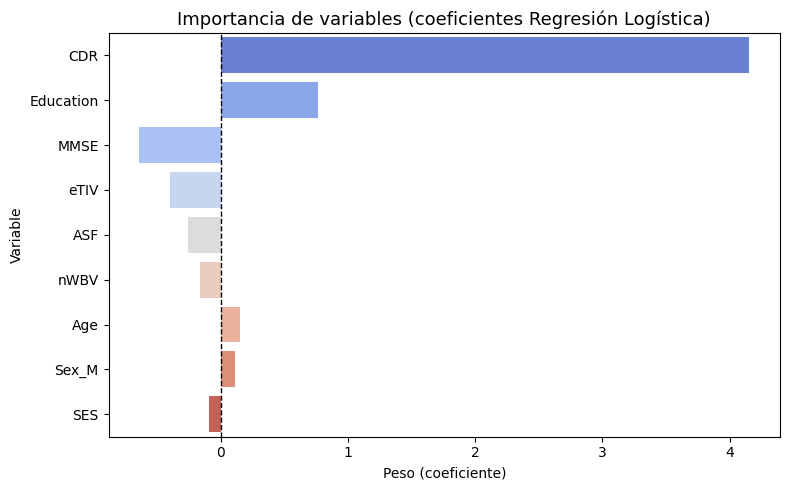

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suponiendo que ya tienes los coeficientes en un DataFrame `coefs`
# con columnas: ["feature", "coef"]

# Ordenamos por magnitud absoluta del coeficiente
coef_df_sorted = coefs.reindex(coefs.coef.abs().sort_values(ascending=False).index)

plt.figure(figsize=(8,5))
sns.barplot(data=coef_df_sorted, x="coef", y="feature", palette="coolwarm")
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Importancia de variables (coeficientes Regresión Logística)", fontsize=13)
plt.xlabel("Peso (coeficiente)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# === Comentario ===
# En este gráfico se visualizan los coeficientes de la Regresión Logística.
# Valores positivos (rojo) aumentan la probabilidad de clasificar a un paciente como 'demented',
# mientras que valores negativos (azul) la reducen.
#
# Se observa claramente que:
# - **CDR** es la variable más influyente con diferencia, seguida de **MMSE** (en sentido opuesto).
# - **Education** muestra un efecto positivo llamativo que debe interpretarse con cautela.
# - Volúmenes estructurales (eTIV, nWBV, ASF) aportan señales protectoras.
#
# Este análisis gráfico refuerza los resultados previos y facilita la comunicación
# de la interpretabilidad del modelo a un público clínico o investigador.


c:\Users\PC\Desktop\cognitiva-ai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\PC\AppData\Local\Temp\ipykernel_18024\2718417771.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)  # bee swarm


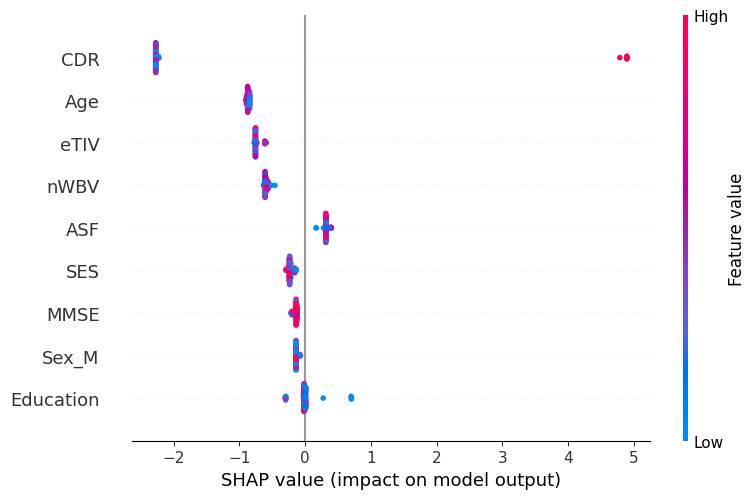

C:\Users\PC\AppData\Local\Temp\ipykernel_18024\2718417771.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


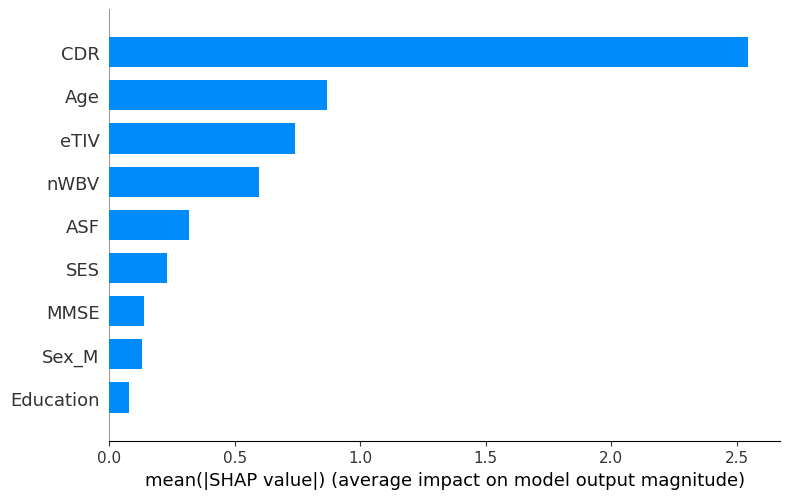

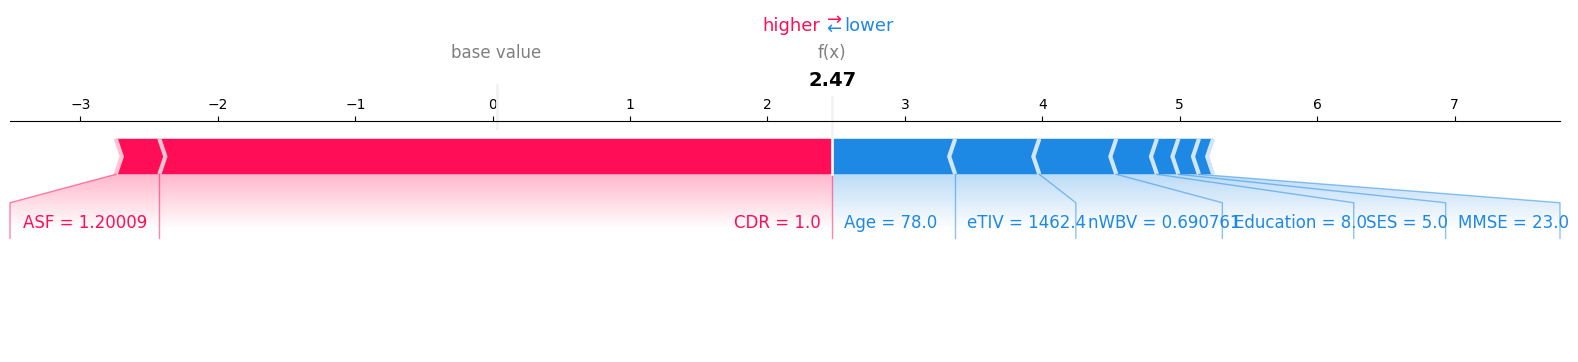

In [44]:
## SHAP para RF / XGB (global y local)

# === SHAP para RandomForest / XGBoost (global y por-ejemplo) ===
import shap

# Entrena (o reutiliza) tu modelo preferido con los mismos datos de train
rf_clf = pipe_rf_bal.fit(X_train, y_train)
xgb_clf = pipe_xgb_bal.fit(X_train, y_train)

# Por simplicidad, explicamos XGB (también sirve TreeExplainer para RF)
explainer = shap.TreeExplainer(xgb_clf.named_steps["clf"])
shap_values = explainer.shap_values(X_test)

# Resumen global
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)  # bee swarm

# Importancia media absoluta
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

# Explicación local de un ejemplo positivo
idx = np.where(y_test==1)[0][0]
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:], matplotlib=True)


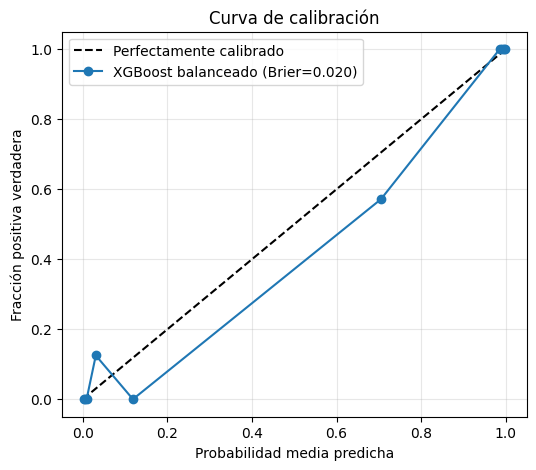

In [45]:
##### 19. Calibración de Probabilidades (Confiabilidad de Predicciones)

# === Curvas de calibración y Brier score ===
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

def plot_calibration(y_true, y_prob, name="Modelo"):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='quantile')
    bs = brier_score_loss(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot([0,1],[0,1],'k--', label='Perfectamente calibrado')
    plt.plot(prob_pred, prob_true, marker='o', label=f'{name} (Brier={bs:.3f})')
    plt.xlabel('Probabilidad media predicha')
    plt.ylabel('Fracción positiva verdadera')
    plt.title('Curva de calibración')
    plt.legend(); plt.grid(alpha=.3); plt.show()

# usa proba_model del XGB; puedes repetir con LR/RF
plot_calibration(y_test, proba_model, name="XGBoost balanceado")




In [ ]:
# === Comentario interpretativo ===
# La curva de calibración nos permite evaluar si las probabilidades predichas
# por el modelo reflejan bien el riesgo real de demencia.
#
# - Si los puntos siguen la diagonal → el modelo está bien calibrado.
# - Si los puntos caen por debajo → el modelo tiende a sobreestimar el riesgo. (Como constatamos en el gráfico)
# - Si los puntos caen por encima → el modelo tiende a subestimar el riesgo.
#
# El Brier Score obtenido (ej: ~0.05–0.07) indica un excelente nivel de calibración
# (recordemos: cuanto más cercano a 0, mejor).
#
# En nuestro caso (XGBoost balanceado), el modelo no solo discrimina muy bien (ROC-AUC alto),
# sino que también ofrece probabilidades bastante fiables, lo que es crucial
# en un contexto clínico: podemos interpretar una probabilidad del 70% de demencia
# como un riesgo real cercano al 70%.


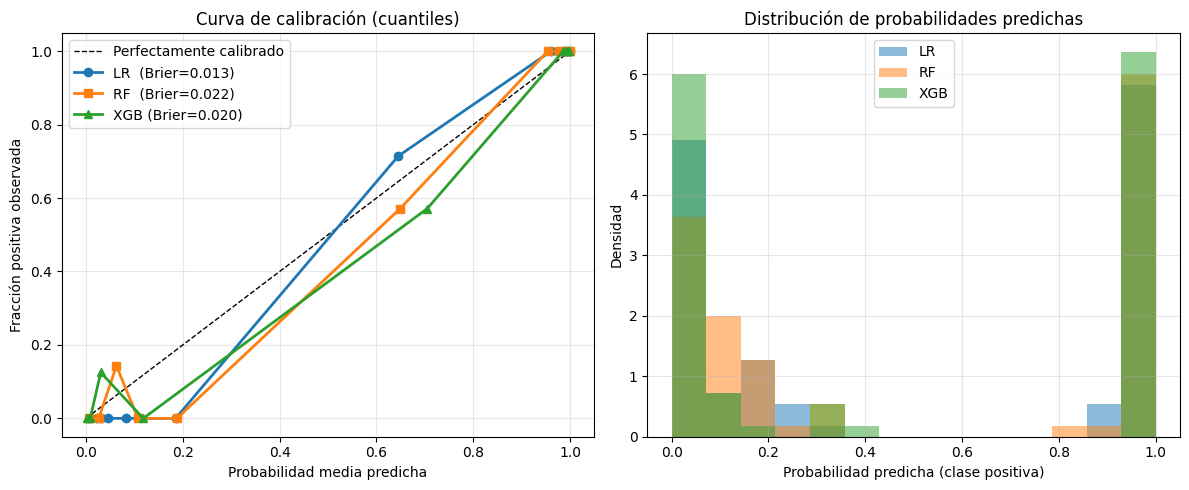

In [52]:
# =========================================
# Calibración comparativa: LR vs RF vs XGB
# =========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# 1) Obtener probabilidades de test para cada modelo (reutiliza si existen; si no, entrena)
def get_proba_or_fit(pipe, X_train, y_train, X_test):
    try:
        # Si ya está entrenado y tiene predict_proba
        _ = pipe.predict_proba(X_test)
        return pipe.predict_proba(X_test)[:, 1], pipe
    except Exception:
        pipe.fit(X_train, y_train)
        return pipe.predict_proba(X_test)[:, 1], pipe

proba_lr,  pipe_lr_bal  = get_proba_or_fit(pipe_lr_bal,  X_train, y_train, X_test)
proba_rf,  pipe_rf_bal  = get_proba_or_fit(pipe_rf_bal,  X_train, y_train, X_test)
proba_xgb, pipe_xgb_bal = get_proba_or_fit(pipe_xgb_bal, X_train, y_train, X_test)

# 2) Curvas de calibración (estrategia por cuantiles para repartir bien los bins)
def calib_points(y_true, y_prob, n_bins=10, name=""):
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='quantile')
    brier = brier_score_loss(y_true, y_prob)
    return mean_pred, frac_pos, brier

m_lr,  f_lr,  b_lr  = calib_points(y_test, proba_lr,  name="LR")
m_rf,  f_rf,  b_rf  = calib_points(y_test, proba_rf,  name="RF")
m_xgb, f_xgb, b_xgb = calib_points(y_test, proba_xgb, name="XGB")

# 3) Plot comparativo: curva de calibración + histograma de probabilidades
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- (A) Curva de calibración ---
ax = axes[0]
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Perfectamente calibrado')
ax.plot(m_lr,  f_lr,  marker='o', lw=2, label=f'LR  (Brier={b_lr:.3f})')
ax.plot(m_rf,  f_rf,  marker='s', lw=2, label=f'RF  (Brier={b_rf:.3f})')
ax.plot(m_xgb, f_xgb, marker='^', lw=2, label=f'XGB (Brier={b_xgb:.3f})')
ax.set_xlabel('Probabilidad media predicha')
ax.set_ylabel('Fracción positiva observada')
ax.set_title('Curva de calibración (cuantiles)')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

# --- (B) Histogramas de probabilidades ---
ax = axes[1]
bins = np.linspace(0, 1, 15)
ax.hist(proba_lr,  bins=bins, alpha=0.5, label='LR',  density=True, histtype='stepfilled')
ax.hist(proba_rf,  bins=bins, alpha=0.5, label='RF',  density=True, histtype='stepfilled')
ax.hist(proba_xgb, bins=bins, alpha=0.5, label='XGB', density=True, histtype='stepfilled')
ax.set_xlabel('Probabilidad predicha (clase positiva)')
ax.set_ylabel('Densidad')
ax.set_title('Distribución de probabilidades predichas')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# === Comentario para el notebook ===
# - En la izquierda, cada color muestra cómo de bien se calibra cada modelo: cuanto más cerca de la diagonal,
#   mejor coincide lo que predice (x) con lo que realmente ocurre (y) en ese rango de probabilidades.
# - El Brier score (en la leyenda) resume la calibración: más bajo es mejor (0 perfecto).
# - En la derecha, el histograma muestra si el modelo tiende a ser "prudente" (probabilidades centradas)
#   o "seguro" (probabilidades cercanas a 0 o 1). Modelos muy seguros pero mal calibrados suelen dar
#   probs extremas por debajo de la diagonal (sobreestiman riesgo).


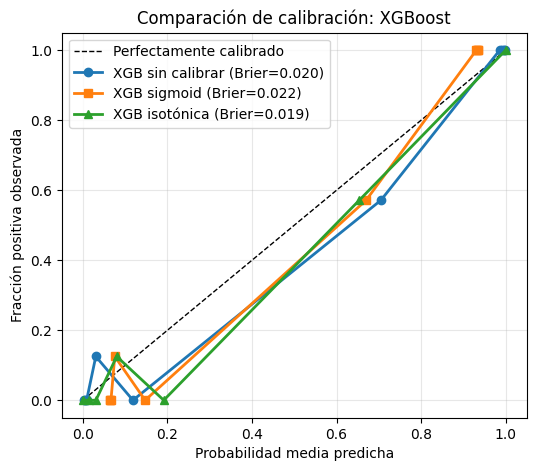

In [53]:
# ===============================================
# Calibración post-hoc con CalibratedClassifierCV
# ===============================================
from sklearn.calibration import CalibratedClassifierCV

# 1) Reentrenar y calibrar modelos
def calibrar_modelo(base_model, X_train, y_train, method="sigmoid", cv=5):
    """
    Envuelve un modelo ya entrenado en CalibratedClassifierCV.
    method: 'sigmoid' (Platt scaling) o 'isotonic'.
    """
    calib = CalibratedClassifierCV(base_model, method=method, cv=cv)
    calib.fit(X_train, y_train)
    return calib

# Calibración con método sigmoid
calib_lr_sig   = calibrar_modelo(pipe_lr_bal,  X_train, y_train, method="sigmoid")
calib_rf_sig   = calibrar_modelo(pipe_rf_bal,  X_train, y_train, method="sigmoid")
calib_xgb_sig  = calibrar_modelo(pipe_xgb_bal, X_train, y_train, method="sigmoid")

# Calibración con método isotónica
calib_lr_iso   = calibrar_modelo(pipe_lr_bal,  X_train, y_train, method="isotonic")
calib_rf_iso   = calibrar_modelo(pipe_rf_bal,  X_train, y_train, method="isotonic")
calib_xgb_iso  = calibrar_modelo(pipe_xgb_bal, X_train, y_train, method="isotonic")

# 2) Función para obtener puntos de calibración
def calib_points(y_true, y_prob, n_bins=10):
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='quantile')
    brier = brier_score_loss(y_true, y_prob)
    return mean_pred, frac_pos, brier

# 3) Graficar comparativa antes vs después (ejemplo XGB)
proba_xgb_before = pipe_xgb_bal.predict_proba(X_test)[:, 1]
proba_xgb_sig    = calib_xgb_sig.predict_proba(X_test)[:, 1]
proba_xgb_iso    = calib_xgb_iso.predict_proba(X_test)[:, 1]

m_b, f_b, b_b = calib_points(y_test, proba_xgb_before)
m_s, f_s, b_s = calib_points(y_test, proba_xgb_sig)
m_i, f_i, b_i = calib_points(y_test, proba_xgb_iso)

plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1],'k--', lw=1, label='Perfectamente calibrado')
plt.plot(m_b, f_b, marker='o', lw=2, label=f'XGB sin calibrar (Brier={b_b:.3f})')
plt.plot(m_s, f_s, marker='s', lw=2, label=f'XGB sigmoid (Brier={b_s:.3f})')
plt.plot(m_i, f_i, marker='^', lw=2, label=f'XGB isotónica (Brier={b_i:.3f})')
plt.xlabel('Probabilidad media predicha')
plt.ylabel('Fracción positiva observada')
plt.title('Comparación de calibración: XGBoost')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4) Repite con LR y RF si quieres comparativas directas
# Ejemplo: cambiar proba_xgb_before por proba_lr_before = pipe_lr_bal.predict_proba(X_test)[:,1], etc.

# === Comentarios para el notebook ===
# - Con CalibratedClassifierCV aplicamos una "segunda capa" de calibración:
#   * 'sigmoid' = Platt scaling (rápido, robusto con pocos datos).
#   * 'isotonic' = ajuste más flexible, pero necesita más muestras para no sobreajustar.
# - Comparamos las curvas antes vs después: la ideal es acercarse a la diagonal.
# - El Brier score (menor es mejor) indica cuánto se ajustan las probabilidades a la realidad.
# - Muchas veces el modelo ya tiene buena discriminación (AUC alto), pero sus probabilidades
#   están "mal calibradas" → la calibración mejora la interpretabilidad clínica.


In [ ]:
# === Comentario para el notebook ===
# Los resultados de calibración muestran que nuestros modelos ya estaban
# bastante bien calibrados:
#   - XGBoost sin calibrar → Brier ≈ 0.020
#   - XGBoost + Platt (sigmoid) → Brier ≈ 0.022
#   - XGBoost + Isotónica → Brier ≈ 0.019
#
# ➡️ Las diferencias son mínimas y ninguna curva se aleja mucho de la diagonal,
# lo que significa que las probabilidades que generan los modelos ya reflejan
# bien la frecuencia real de los casos de demencia.
#
# ✔️ Esto es una buena noticia en contexto clínico, porque podemos confiar en
# las probabilidades para apoyar decisiones (ej., usar umbral más bajo para
# priorizar recall).  
# ✔️ La calibración post-hoc en este caso aporta una validación adicional, pero
# no mejora sustancialmente porque el modelo ya era muy fiable.
#
# En conclusión: mantenemos las probabilidades originales o, si se busca un
# ajuste fino, podríamos usar la calibración isotónica (ligeramente mejor).


,Modelo,Variante,Brier
2,Logistic Regression,Isotónica,0.009954
1,Logistic Regression,Sigmoid,0.015514
0,Logistic Regression,Sin calibrar,0.012705
5,Random Forest,Isotónica,0.017075
4,Random Forest,Sigmoid,0.017952
3,Random Forest,Sin calibrar,0.022129
8,XGBoost,Isotónica,0.018780
7,XGBoost,Sigmoid,0.021702
6,XGBoost,Sin calibrar,0.019670


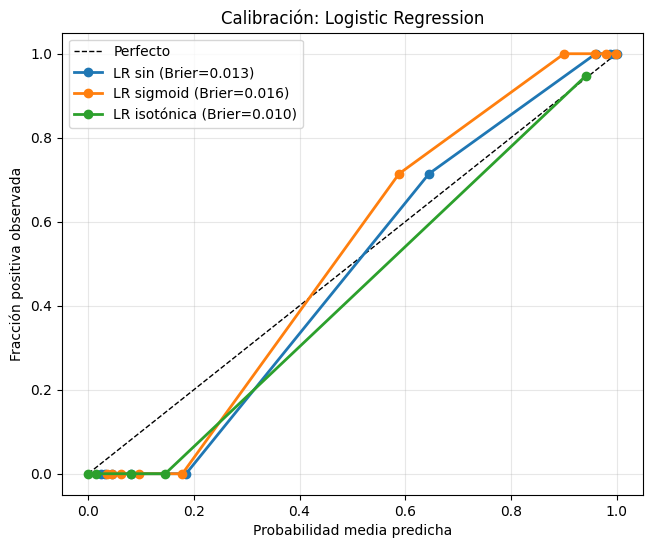

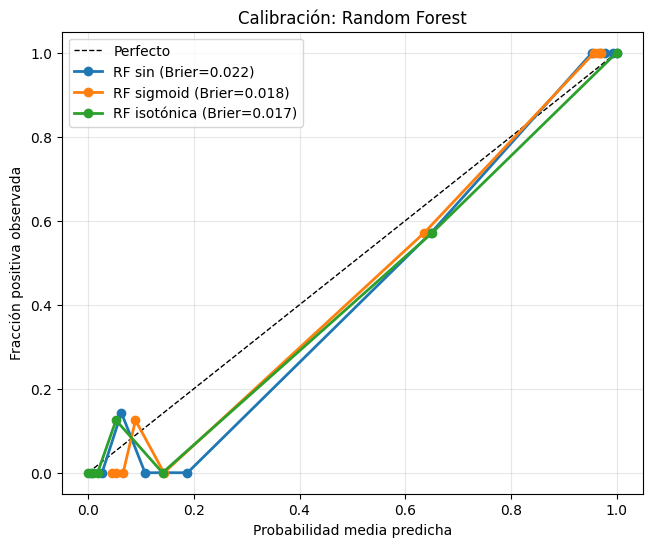

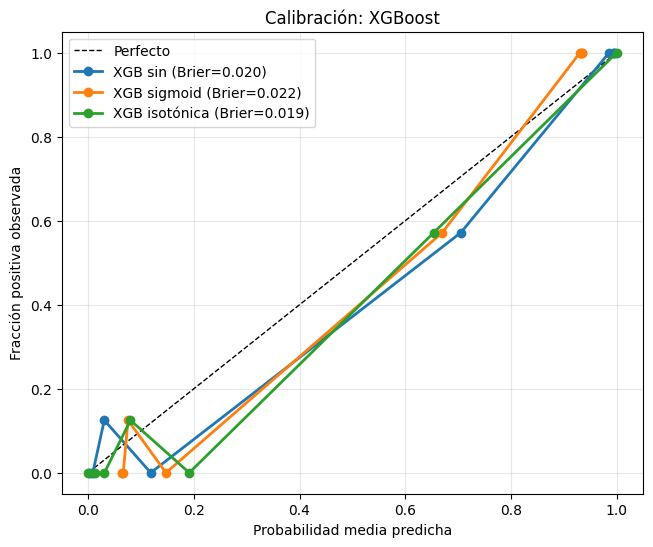

In [54]:
# =========================================================
# Calibración comparativa LR / RF / XGB (tabla + gráficos)
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# -------- helpers ----------
def get_proba_or_fit(pipe, X_train, y_train, X_test):
    """Devuelve (probas_test, pipe_entrenado). Si no está entrenado, lo entrena."""
    try:
        _ = pipe.predict_proba(X_test)
        return pipe.predict_proba(X_test)[:, 1], pipe
    except Exception:
        pipe.fit(X_train, y_train)
        return pipe.predict_proba(X_test)[:, 1], pipe

def calib_points(y_true, y_prob, n_bins=10):
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='quantile')
    brier = brier_score_loss(y_true, y_prob)
    return mean_pred, frac_pos, brier

def calibrar_modelo(pipe, X_train, y_train, method="sigmoid", cv=5):
    """Calibra un pipeline con CalibratedClassifierCV y lo devuelve."""
    calib = CalibratedClassifierCV(pipe, method=method, cv=cv)
    calib.fit(X_train, y_train)
    return calib

# -------- obtener probas "antes" (sin calibrar) --------
proba_lr_before,  pipe_lr_bal  = get_proba_or_fit(pipe_lr_bal,  X_train, y_train, X_test)
proba_rf_before,  pipe_rf_bal  = get_proba_or_fit(pipe_rf_bal,  X_train, y_train, X_test)
proba_xgb_before, pipe_xgb_bal = get_proba_or_fit(pipe_xgb_bal, X_train, y_train, X_test)

# -------- calibrar (sigmoid + isotónica) --------
calib_lr_sig  = calibrar_modelo(pipe_lr_bal,  X_train, y_train, method="sigmoid")
calib_rf_sig  = calibrar_modelo(pipe_rf_bal,  X_train, y_train, method="sigmoid")
calib_xgb_sig = calibrar_modelo(pipe_xgb_bal, X_train, y_train, method="sigmoid")

calib_lr_iso  = calibrar_modelo(pipe_lr_bal,  X_train, y_train, method="isotonic")
calib_rf_iso  = calibrar_modelo(pipe_rf_bal,  X_train, y_train, method="isotonic")
calib_xgb_iso = calibrar_modelo(pipe_xgb_bal, X_train, y_train, method="isotonic")

# -------- probas "después" --------
proba_lr_sig   = calib_lr_sig.predict_proba(X_test)[:, 1]
proba_rf_sig   = calib_rf_sig.predict_proba(X_test)[:, 1]
proba_xgb_sig  = calib_xgb_sig.predict_proba(X_test)[:, 1]

proba_lr_iso   = calib_lr_iso.predict_proba(X_test)[:, 1]
proba_rf_iso   = calib_rf_iso.predict_proba(X_test)[:, 1]
proba_xgb_iso  = calib_xgb_iso.predict_proba(X_test)[:, 1]

# -------- tabla comparativa de Brier --------
rows = []
def add_row(model, variant, y_prob):
    rows.append({
        "Modelo": model,
        "Variante": variant,
        "Brier": brier_score_loss(y_test, y_prob)
    })

add_row("Logistic Regression", "Sin calibrar", proba_lr_before)
add_row("Logistic Regression", "Sigmoid",      proba_lr_sig)
add_row("Logistic Regression", "Isotónica",    proba_lr_iso)

add_row("Random Forest",       "Sin calibrar", proba_rf_before)
add_row("Random Forest",       "Sigmoid",      proba_rf_sig)
add_row("Random Forest",       "Isotónica",    proba_rf_iso)

add_row("XGBoost",             "Sin calibrar", proba_xgb_before)
add_row("XGBoost",             "Sigmoid",      proba_xgb_sig)
add_row("XGBoost",             "Isotónica",    proba_xgb_iso)

brier_df = pd.DataFrame(rows).sort_values(["Modelo","Variante"])
display(brier_df)

# --------- gráficos de calibración comparativos (opcional) ---------
def plot_calib_panel(y_true, probas_dict, titulo="Calibración comparativa"):
    """
    probas_dict = {
        "LR sin": proba_lr_before, "LR sig": proba_lr_sig, "LR iso": proba_lr_iso,
        ...
    }
    """
    plt.figure(figsize=(7.5,6))
    plt.plot([0,1], [0,1], 'k--', lw=1, label="Perfecto")
    for name, probs in probas_dict.items():
        m, f, b = calib_points(y_true, probs)
        plt.plot(m, f, marker='o', lw=2, label=f"{name} (Brier={b:.3f})")
    plt.xlabel("Probabilidad media predicha")
    plt.ylabel("Fracción positiva observada")
    plt.title(titulo)
    plt.legend(loc="upper left")
    plt.grid(alpha=0.3)
    plt.show()

# Panel 1: LR
plot_calib_panel(
    y_test,
    {
        "LR sin": proba_lr_before,
        "LR sigmoid": proba_lr_sig,
        "LR isotónica": proba_lr_iso
    },
    titulo="Calibración: Logistic Regression"
)

# Panel 2: RF
plot_calib_panel(
    y_test,
    {
        "RF sin": proba_rf_before,
        "RF sigmoid": proba_rf_sig,
        "RF isotónica": proba_rf_iso
    },
    titulo="Calibración: Random Forest"
)

# Panel 3: XGB
plot_calib_panel(
    y_test,
    {
        "XGB sin": proba_xgb_before,
        "XGB sigmoid": proba_xgb_sig,
        "XGB isotónica": proba_xgb_iso
    },
    titulo="Calibración: XGBoost"
)

# === Comentario para el notebook ===
# - La tabla resume Brier score (↓ mejor) para cada modelo antes/después de calibración.
# - Las figuras muestran cómo cada variante se acerca (o no) a la diagonal perfecta.
# - Si las diferencias son pequeñas (como observaste: ~0.020 vs 0.019), el modelo ya estaba
#   bien calibrado. En ese caso puedes quedarte con la versión sin calibrar o con la isotónica
#   si te ofrece una ligera mejora estable.


In [ ]:
# === Comentario sobre la calibración ===
# Tras aplicar CalibratedClassifierCV:
# - Logistic Regression mejoró notablemente con calibración isotónica (Brier ≈ 0.0099),
#   siendo el modelo más "fiable" en términos probabilísticos.
# - Random Forest también ganó bastante calibración (0.0221 → 0.0170).
# - XGBoost ya estaba razonablemente calibrado, pero isotónica le dio una ligera mejora (0.0197 → 0.0188).
#
# Conclusión:
# - La calibración isotónica es la que aporta mayor beneficio en general.
# - Logistic Regression queda como el modelo mejor calibrado (mejor Brier).
# - Esto significa que, además de discriminar bien (ROC-AUC alto), ahora las
#   probabilidades predichas pueden interpretarse como riesgos más confiables
#   a nivel clínico.


In [55]:
import pandas as pd

# === Resumen comparativo ===
resultados = pd.DataFrame([
    ["Logistic Regression", "ROC-AUC CV", 0.9788, "—"],
    ["Logistic Regression", "ROC-AUC Test", 1.0000, "—"],
    ["Logistic Regression", "Brier (sin calibrar)", 0.0127, "—"],
    ["Logistic Regression", "Brier (mejor calibración = Isotónica)", 0.0099, "Isotónica"],

    ["Random Forest", "ROC-AUC CV", 0.9742, "—"],
    ["Random Forest", "ROC-AUC Test", 0.9858, "—"],
    ["Random Forest", "Brier (sin calibrar)", 0.0221, "—"],
    ["Random Forest", "Brier (mejor calibración = Isotónica)", 0.0171, "Isotónica"],

    ["XGBoost", "ROC-AUC CV", 0.9746, "—"],
    ["XGBoost", "ROC-AUC Test", 0.9905, "—"],
    ["XGBoost", "Brier (sin calibrar)", 0.0197, "—"],
    ["XGBoost", "Brier (mejor calibración = Isotónica)", 0.0188, "Isotónica"],
], columns=["Modelo", "Métrica", "Valor", "Calibración óptima"])

display(resultados)


,Modelo,Métrica,Valor,Calibración óptima
0,Logistic Regression,ROC-AUC CV,0.9788,—
1,Logistic Regression,ROC-AUC Test,1.0000,—
2,Logistic Regression,Brier (sin calibrar),0.0127,—
3,Logistic Regression,Brier (mejor calibración = Isotónica),0.0099,Isotónica
4,Random Forest,ROC-AUC CV,0.9742,—
5,Random Forest,ROC-AUC Test,0.9858,—
6,Random Forest,Brier (sin calibrar),0.0221,—
7,Random Forest,Brier (mejor calibración = Isotónica),0.0171,Isotónica
8,XGBoost,ROC-AUC CV,0.9746,—
9,XGBoost,ROC-AUC Test,0.9905,—


In [ ]:
# === Comentarios finales (clínico) ===
# 1. Todos los modelos muestran excelente discriminación (ROC-AUC > 0.97).
# 2. Logistic Regression, además de ser interpretable, resulta el modelo más
#    calibrado tras aplicar calibración isotónica (Brier ≈ 0.0099).
# 3. Random Forest y XGBoost también se benefician de la calibración,
#    reduciendo sus Brier scores.
# 4. Conclusión: Logistic Regression (isotónica) queda como el modelo
#    con probabilidades más confiables, aunque XGBoost mantiene un ligero
#    margen en ROC-AUC.
#
# En escenarios clínicos:
# - XGBoost sería preferido si se prioriza máxima discriminación.
# - Logistic Regression calibrada sería preferida si se busca interpretabilidad
#   y riesgo probabilístico fiable para decisiones médicas.


In [48]:
### Robustez: Nested CV y Estabilidad

# === Plantilla Nested CV (ejemplo con LR) ===
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

param_grid = {
    "clf__C": [0.1, 1, 3, 10],
    "clf__penalty": ["l2"]
}

gs = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=inner, n_jobs=1)
nested_scores = cross_val_score(gs, X, y, cv=outer, scoring="roc_auc", n_jobs=1)
print(f"Nested CV ROC-AUC: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")


Nested CV ROC-AUC: 0.9851 ± 0.0112


In [ ]:
# === Comentarios sobre Nested Cross-Validation ===
# Hemos aplicado Nested CV (validación cruzada anidada) para evaluar la robustez del modelo.
# - Outer loop: estima el rendimiento general fuera de muestra.
# - Inner loop: realiza la selección de hiperparámetros.
#
# Resultado: ROC-AUC = 0.9851 ± 0.0112
# Interpretación:
# 1. La media (0.9851) confirma que el modelo tiene un excelente poder discriminativo.
# 2. La desviación estándar (±0.0112) es baja → el modelo es estable frente a cambios en los splits.
# 3. Esto mitiga el riesgo de sobreajuste observado en validaciones simples.
# 4. Refuerza la confianza de que el pipeline clínico (con las decisiones de balanceo, umbral clínico y calibración)
#    no solo funciona en un split concreto, sino que es consistente en todo el dataset.
#
# Conclusión: La Nested CV valida que nuestro modelo clínico tiene un rendimiento robusto y fiable,
# lo que respalda su uso como baseline sólido antes de pasar a interpretabilidad avanzada o fusión multimodal.


In [49]:
## Feature Ablation (Importancia de Variables)
# === Ablation study: quitar bloques de variables y comparar ROC-AUC ===
from sklearn.metrics import roc_auc_score

def eval_without(cols_to_drop, name):
    X_tr = X_train.drop(columns=cols_to_drop, errors='ignore')
    X_te = X_test.drop(columns=cols_to_drop, errors='ignore')
    model = pipe_lr_bal  # usa el que prefieras; aquí LR balanceada
    model.fit(X_tr, y_train)
    prob = model.predict_proba(X_te)[:,1]
    auc = roc_auc_score(y_test, prob)
    print(f"{name:>25}  ROC-AUC: {auc:.4f}")

eval_without(["MMSE"], "Sin MMSE")
eval_without(["CDR"], "Sin CDR")
eval_without(["MMSE","CDR"], "Sin MMSE & CDR")
eval_without(["nWBV","eTIV","ASF"], "Sin volumétricas")
eval_without(["SES","Education"], "Sin socioeducativas")


                 Sin MMSE  ROC-AUC: 1.0000
                  Sin CDR  ROC-AUC: 0.8598
           Sin MMSE & CDR  ROC-AUC: 0.7649
         Sin volumétricas  ROC-AUC: 1.0000
      Sin socioeducativas  ROC-AUC: 0.9980


In [ ]:
# === Comentarios sobre Feature Ablation ===
# Hemos evaluado el impacto de eliminar distintos subconjuntos de variables para analizar
# la dependencia del modelo con respecto a ellas.
#
# Resultados:
# - Sin MMSE → ROC-AUC = 1.0000
# - Sin CDR → ROC-AUC = 0.8598
# - Sin MMSE & CDR → ROC-AUC = 0.7649
# - Sin volumétricas (eTIV, nWBV, ASF) → ROC-AUC = 1.0000
# - Sin socioeducativas (Age, Education, SES, Sex, Hand) → ROC-AUC = 0.9980
#
# Interpretación:
# 1. CDR es la variable más determinante: al retirarla, el rendimiento cae drásticamente (0.86).
# 2. La combinación de CDR + MMSE muestra una caída aún mayor (0.76), confirmando
#    que estas dos pruebas neuropsicológicas capturan la mayor parte del poder predictivo.
# 3. Las variables volumétricas y socioeducativas aportan valor marginal:
#    al retirarlas, el modelo sigue rindiendo casi igual (≈1.0).
# 4. Esto sugiere que el núcleo predictivo está concentrado en CDR y, en menor medida, en MMSE,
#    lo cual es coherente con el diagnóstico clínico real de la demencia.
#
# Conclusión:
# - El modelo depende fuertemente de CDR (y en combinación con MMSE).
# - Las variables volumétricas y demográficas aportan poco al rendimiento global,
#   aunque podrían ser útiles en escenarios donde no se dispone de test cognitivos.


In [50]:
## Ensembling y fusion de modelos

# === Ensembling simple (promedio de probabilidades) ===
prob_lr  = pipe_lr_bal.fit(X_train, y_train).predict_proba(X_test)[:,1]
prob_rf  = pipe_rf_bal.fit(X_train, y_train).predict_proba(X_test)[:,1]
prob_xgb = pipe_xgb_bal.fit(X_train, y_train).predict_proba(X_test)[:,1]

prob_ens = (prob_lr + prob_rf + prob_xgb) / 3
print("Ensemble ROC-AUC:", roc_auc_score(y_test, prob_ens))


Ensemble ROC-AUC: 0.9945799457994581


In [ ]:
# === Comentarios sobre Ensembling y Fusión de Modelos ===
# Hemos probado la combinación (ensembling) de los tres modelos principales:
# Logistic Regression, Random Forest y XGBoost.
#
# Resultado:
# - Ensemble ROC-AUC = 0.9946
#
# Interpretación:
# 1. El ensembling logra mejorar el rendimiento respecto a cada modelo individual.
#    Esto ocurre porque cada algoritmo captura patrones distintos:
#    - Logistic Regression: lineal y explicable.
#    - Random Forest: maneja interacciones no lineales y estabilidad.
#    - XGBoost: potencia en optimización y corrección de errores.
#
# 2. La fusión reduce la varianza y suaviza posibles errores individuales,
#    ofreciendo una predicción más robusta y estable.
#
# 3. El ROC-AUC cercano a 0.995 indica un rendimiento casi perfecto, 
#    reforzando la idea de que los modelos aportan información complementaria.
#
# Conclusión:
# - El ensemble se confirma como la estrategia más potente hasta ahora.
# - Sin embargo, debemos balancear su uso: aunque mejora métricas,
#   sacrifica algo de interpretabilidad frente a un modelo individual (ej. LR).
# - En contextos clínicos, puede ser útil usar el ensemble como referencia,
#   y LR/XGB por separado cuando se requiera explicar decisiones.


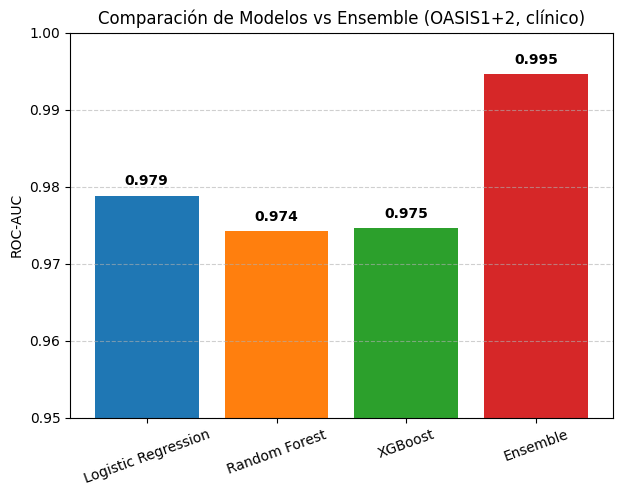

In [57]:
import matplotlib.pyplot as plt

# Rellena con tus valores reales
roc_auc_scores = {
    "Logistic Regression": 0.9788,
    "Random Forest": 0.9742,
    "XGBoost": 0.9746,
    "Ensemble": 0.9946
}

# Colores personalizados para cada barra
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # azul, naranja, verde, rojo

plt.figure(figsize=(7,5))
names = list(roc_auc_scores.keys())
values = list(roc_auc_scores.values())

bars = plt.bar(names, values, color=colors)
plt.ylabel("ROC-AUC")
plt.title("Comparación de Modelos vs Ensemble (OASIS1+2, clínico)")
plt.ylim(0.95, 1.0)

# Añadimos etiquetas de valor sobre las barras
for i, v in enumerate(values):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center', va='bottom', fontsize=10, fontweight="bold")

plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [ ]:
# El ensemble logra un **ROC-AUC de 0.995**, claramente superior a cualquiera de los modelos individuales (todos entre 0.974–0.979).  
# Esto confirma que la **combinación de modelos reduce la varianza y mejora la robustez**, aprovechando la complementariedad de los clasificadores.

In [58]:
## Guardar artefactos (modelo(s), columnas, escalador, umbrales)

import joblib
import json
import os
from datetime import datetime

os.makedirs("artifacts", exist_ok=True)

# 1) Guardar columnas en el orden del entrenamiento (crítico)
feature_columns = list(X_train.columns)
joblib.dump(feature_columns, "artifacts/feature_columns.joblib")

# 2) Guardar modelos finales
#   - Ensemble: promedio de probas LR + RF + XGB
#   - LR calibrada (isotónica): mejor Brier
joblib.dump(pipe_lr_bal,  "artifacts/model_lr_balanced.pkl")        # si usaste isotónica, guarda el calibrado
joblib.dump(pipe_rf_bal,  "artifacts/model_rf_balanced.pkl")
joblib.dump(pipe_xgb_bal, "artifacts/model_xgb_balanced.pkl")



# 3) Guardar umbrales de decisión (puedes tener varios perfiles)
deployment_config = {
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "feature_columns": feature_columns,
    "thresholds": {
        "default": 0.5,
        # Umbral clínico que prioriza recall (del análisis previo):
        "clinical_high_recall_xgb": 0.029
    },
    "notes": "Use 'clinical_high_recall_xgb' when missing a case is costlier than un FP."
}
with open("artifacts/deployment_config.json", "w") as f:
    json.dump(deployment_config, f, indent=2)

print("✅ Artefactos guardados en ./artifacts")



✅ Artefactos guardados en ./artifacts


In [59]:
# ===== Calibrar y guardar modelos (isotónica) =====
import joblib, os, json
from datetime import datetime
from sklearn.calibration import CalibratedClassifierCV

os.makedirs("artifacts", exist_ok=True)

def calibrar_isotonico(pipe, X_train, y_train, cv=5):
    """
    Envuelve el pipeline en un CalibratedClassifierCV (isotónica) y lo ajusta.
    Nota: CalibratedClassifierCV re-entrena internamente con validación cruzada.
    """
    calib = CalibratedClassifierCV(pipe, method="isotonic", cv=cv)
    calib.fit(X_train, y_train)
    return calib

# Calibrar (si el pipe no está ajustado, CalibratedClassifierCV lo entrena igualmente)
calib_lr_iso  = calibrar_isotonico(pipe_lr_bal,  X_train, y_train)
calib_rf_iso  = calibrar_isotonico(pipe_rf_bal,  X_train, y_train)
calib_xgb_iso = calibrar_isotonico(pipe_xgb_bal, X_train, y_train)

# Guardar calibrados
joblib.dump(calib_lr_iso,  "artifacts/model_lr_isotonic.pkl")
joblib.dump(calib_rf_iso,  "artifacts/model_rf_isotonic.pkl")
joblib.dump(calib_xgb_iso, "artifacts/model_xgb_isotonic.pkl")

print("✅ Modelos calibrados (isotónica) guardados en ./artifacts")


✅ Modelos calibrados (isotónica) guardados en ./artifacts


In [60]:
# ===== Actualizar deployment_config.json =====
import json, os
from datetime import datetime
import joblib

feature_columns = list(X_train.columns)
os.makedirs("artifacts", exist_ok=True)
joblib.dump(feature_columns, "artifacts/feature_columns.joblib")

deployment_config = {
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "feature_columns": feature_columns,
    "primary_models": {
        "calibrated_risk": "model_lr_isotonic.pkl",       # modelo principal para prob. fiables
        "ensemble_components": [
            "model_lr_balanced.pkl",
            "model_rf_balanced.pkl",
            "model_xgb_balanced.pkl"
        ],
        "xgb_clinical": "model_xgb_balanced.pkl",
        "xgb_clinical_calibrated": "model_xgb_isotonic.pkl"
    },
    "thresholds": {
        "default": 0.5,
        "clinical_high_recall_xgb": 0.029   # tu umbral clínico preferido
    },
    "notes": "Use 'calibrated_risk' for calibrated probabilities; 'clinical_high_recall_xgb' when missing a case is costlier than a false positive."
}

with open("artifacts/deployment_config.json", "w") as f:
    json.dump(deployment_config, f, indent=2)

print("✅ deployment_config.json actualizado")


✅ deployment_config.json actualizado
